In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

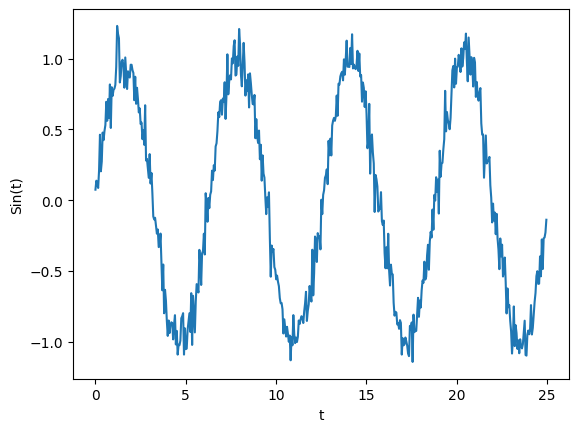

In [2]:
#Параметры
data_count=2000
sequenceLength = 100
batchSize = int(data_count/sequenceLength)
num_layers = 1
hiddenSize = 4
learningRate = 0.02
epochs = 500
noise_level=0.1

#Данные - синусоида+ случаный шум
t=torch.linspace(0,100,data_count)
sin_data_train = torch.sin(t) +noise_level*torch.randn(data_count)
plt.plot(t[0:500],sin_data_train[0:500])
plt.ylabel('Sin(t)')
plt.xlabel('t')
plt.show()

In [3]:
sin_data_test = torch.sin(t) + noise_level*torch.rand(data_count)

class DatasetSin(Dataset):
    def __init__(self, data, sequenceLength):
        self.data = data
        self.sequenceLength = sequenceLength
    def __len__(self):
        return int(torch.floor(torch.tensor(len(self.data)/self.sequenceLength)))

    def __getitem__(self, index):
        data_sequence = self.data[index:index+self.sequenceLength]
        next_value = self.data[index+self.sequenceLength+1]
        return data_sequence, next_value



datasetTrain = DatasetSin(sin_data_train,sequenceLength)
dataLoaderTrain = DataLoader(datasetTrain, batch_size=batchSize, shuffle=True)
for x_data,y_data in dataLoaderTrain:
    print('x_data='+str(x_data))
    print('y_data='+str(y_data))
    break

datasetTest = DatasetSin(sin_data_test,sequenceLength)
dataLoaderTest= DataLoader(datasetTest, batch_size=batchSize, shuffle=True)


x_data=tensor([[ 0.5314,  0.6952,  0.5612,  ..., -0.6742, -0.8019, -0.9328],
        [ 0.0870,  0.2107,  0.4626,  ..., -1.0510, -1.0470, -0.9148],
        [ 0.4244,  0.4889,  0.5314,  ..., -0.6558, -1.0212, -0.6742],
        ...,
        [ 0.6952,  0.5612,  0.7149,  ..., -0.8019, -0.9328, -0.7137],
        [ 0.4889,  0.5314,  0.6952,  ..., -1.0212, -0.6742, -0.8019],
        [ 0.7366,  0.7792,  0.7881,  ..., -0.4480, -0.5978, -0.3743]])
y_data=tensor([-0.5921, -0.7980, -0.9328, -0.9148, -0.3584, -0.6558, -1.0470, -1.0212,
        -0.4480, -0.3501, -0.6742, -0.8019, -0.9298, -0.6509, -0.3743, -0.5978,
        -0.8596, -0.6215, -0.7137, -0.2362])


In [4]:
class RNN(nn.Module):
    def __init__(self, inputSize, hiddenSize, numLayers):
        super(RNN,self).__init__()
        self.RNN = nn.RNN(input_size=inputSize,
                          hidden_size=hiddenSize,
                          num_layers=numLayers,
                          nonlinearity='tanh',
                          batch_first=True)
        self.linear = nn.Linear(hiddenSize,1)

    def forward(self,x,hState):
        # прямой проход через RNN слой
        x, h = self.RNN(x,hState)
        #прямой проход через выходной слой
        y_pred = self.linear(x[:,-1,:])
        return y_pred

modelRNN = RNN(1,hiddenSize,num_layers)
print(modelRNN)

RNN(
  (RNN): RNN(1, 4, batch_first=True)
  (linear): Linear(in_features=4, out_features=1, bias=True)
)


In [5]:
class LSTM(nn.Module):
    def __init__(self, inputSize, hiddenSize, batch_size,num_layers):
        super(LSTM, self).__init__()
        self.hidden_dim = hiddenSize
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=inputSize, hidden_size=hiddenSize,
                            num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(self.hidden_dim, 1)
    def init_hidden(self):
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
    def forward(self, input):
        lstm_out, self.hidden = self.lstm(input)
        y_pred = self.linear(lstm_out[:,-1,:])
        return y_pred

modelLSTM = LSTM(1, hiddenSize, batch_size=batchSize, num_layers=num_layers)
print(modelLSTM)


LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (linear): Linear(in_features=4, out_features=1, bias=True)
)


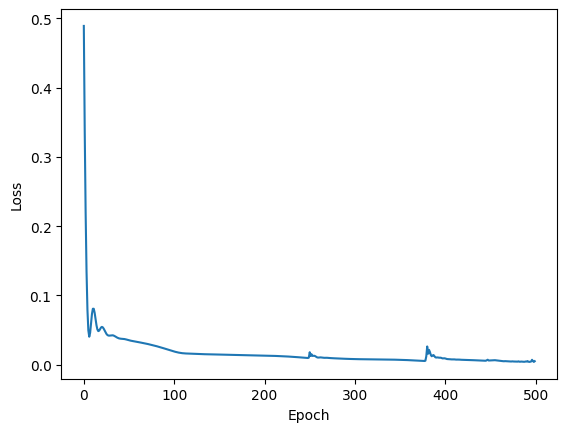

In [6]:
loss_function = nn.MSELoss()
optimizerLSTM = torch.optim.Adam(modelRNN.parameters(), lr=learningRate)
modelRNN.train()
lossHistory = []
for epoch in range(epochs):
    lossTotal = 0
    for x_data,y_data in dataLoaderTrain:
        hddenState = torch.zeros([num_layers, batchSize, hiddenSize])
        y_pred= modelRNN(x_data.reshape([batchSize,sequenceLength, 1]),hddenState)
        loss = loss_function(y_pred.view(-1),y_data)
        modelRNN.zero_grad()
        loss.backward()
        optimizerLSTM.step()
        lossTotal +=loss
    lossHistory.append(lossTotal.item())
plt.plot(lossHistory)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

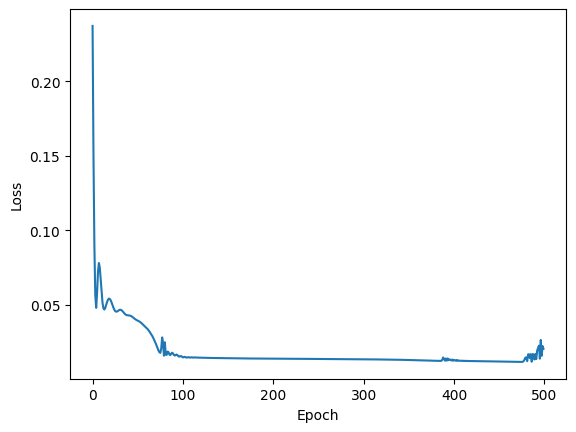

In [7]:
loss_function = nn.MSELoss()
optimizerLSTM = torch.optim.Adam(modelLSTM.parameters(), lr=learningRate)
modelLSTM.train()
lossHistory = []
for epoch in range(epochs):
    lossTotal = 0
    for x_data,y_data in dataLoaderTrain:
        modelLSTM.hidden = modelLSTM.init_hidden()
        y_pred= modelLSTM(x_data.reshape([batchSize,sequenceLength, 1]))
        loss = loss_function(y_pred.view(-1),y_data)
        modelLSTM.zero_grad()
        loss.backward()
        optimizerLSTM.step()
        lossTotal +=loss
    lossHistory.append(lossTotal.item())

plt.plot(lossHistory)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

tensor([[-1.0833],
        [-0.3866],
        [-0.8289],
        [-0.1405],
        [-0.9053],
        [-0.6785],
        [-0.2362],
        [-0.9260],
        [-0.5051],
        [-1.0729],
        [-0.4256],
        [ 0.4665],
        [-0.5224],
        [-0.6157],
        [-0.3716],
        [-1.0965],
        [-0.4552],
        [-1.0398],
        [ 0.1440],
        [-0.8263]], grad_fn=<AddmmBackward0>)


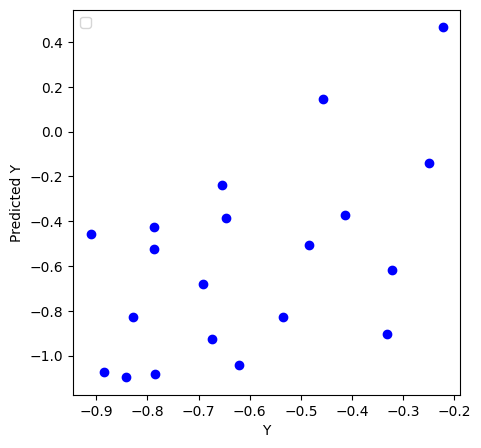

In [8]:
modelRNN.eval()
for x_data,y_data in dataLoaderTest:
    hddenState = torch.zeros([num_layers, batchSize, hiddenSize])
    y_pred= modelRNN(x_data.reshape([batchSize,sequenceLength, 1]),hddenState)
    print(y_pred)
    plt.figure(figsize=(5, 5), dpi=100)
    plt.xlabel("Y")
    plt.ylabel("Predicted Y")
    # Конвертация тензоров в numpy массивы
    y_data = y_data.detach().numpy()
    y_pred = y_pred.detach().numpy()
    plt.scatter(y_data, y_pred, lw=1, color="b")
    plt.legend()
    plt.show()



tensor([[-0.6989],
        [-0.8239],
        [-0.4722],
        [-0.3101],
        [-0.2877],
        [-0.7880],
        [-0.6214],
        [-0.5766],
        [-0.4172],
        [-0.8266],
        [-0.7539],
        [-0.3347],
        [-0.3706],
        [-0.5285],
        [-0.7999],
        [-0.6639],
        [-0.7701],
        [-0.8125],
        [-0.7382],
        [-0.8198]], grad_fn=<AddmmBackward0>)


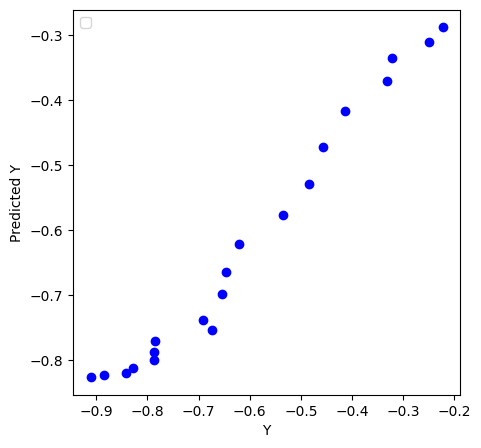

In [9]:

modelLSTM.eval()
for x_data,y_data in dataLoaderTest:
    modelLSTM.hidden = modelLSTM.init_hidden()
    y_pred= modelLSTM(x_data.reshape([batchSize,sequenceLength, 1]))
    print(y_pred)
    plt.figure(figsize=(5, 5), dpi=100)
    plt.xlabel("Y")
    plt.ylabel("Predicted Y")
    # Конвертация тензоров в numpy массивы
    y_data = y_data.detach().numpy()
    y_pred = y_pred.detach().numpy()
    plt.scatter(y_data, y_pred, lw=1, color="b")
    plt.legend()
    plt.show()